### Feature Selection und Modelling

In [29]:
import sys
sys.path = ["", ".."] + sys.path[1:]

In [30]:
import pathlib
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

import numpy as np
import aisfeel

In [31]:
data = pathlib.Path("/space/user/hdreesmann/")
aisdk_home = data / "aisdk"
cargo_tanker_features = aisdk_home / "d_2.joblib"

In [32]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [33]:
import joblib

In [34]:
df = joblib.load(cargo_tanker_features).drop(["latitude","longitude"],axis=1)

In [35]:
abebe = df.query("(sog >=5) & (`navigational_status_Under way using engine`==1)")

In [36]:
def weather_to_mag_and_dir(df):
    def magnitude(u, v):
        return (np.pi/180)*np.sqrt((np.square(u)+np.square(v)))
        
    def direction(u, v):
        return 180 + (180/np.pi*np.arctan2(u,v))
        
    current_u, current_v = df['eastward_sea_water_velocity_unit_m_s-1'], df['northward_sea_water_velocity_unit_m_s-1']
    wind_u, wind_v=  df['eastward_wind_unit_m_s-1'], df['northward_wind_unit_m_s-1']
    df["wind_magnitude"] = magnitude(wind_u,wind_v)
    df["wind_direction"] = direction(wind_u,wind_v)
    df["current_magnitude"] = magnitude(current_u, current_v)
    df["current_direction"] = direction(current_u,current_v)
    return df

def total_wave_period(df):
    df["total_wave_period"] = df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_primary_swell_wave_mean_period_unit_s"] + df["sea_surface_wind_wave_mean_period_unit_s"]
    return df

def outlier_filter(df):
    zscores = ""
    threshold = 5
    filtered = -threshold < zscores < threshold
    return df[filtered]

In [37]:
abebe = abebe.pipe(weather_to_mag_and_dir).pipe(total_wave_period)
abebe = abebe.reset_index()

### Deskriptive Statistik für D_2:

In [40]:
abebe.describe()

mmsi  cog__sum_values  \
count  2.411560e+05    241156.000000   
mean   2.641225e+08      1058.858060   
std    4.971667e+07       550.874941   
min    2.103500e+08         9.690625   
25%    2.306320e+08       647.210352   
50%    2.581680e+08      1017.546854   
75%    2.662120e+08      1496.191353   
max    3.552490e+08      2149.355107   

       heading__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0  \
count                                       2.411560e+05                     
mean                                        6.475631e+00                     
std                                         3.835670e+02                     
min                                         0.000000e+00                     
25%                                         0.000000e+00                     
50%                                         3.155444e-30                     
75%                                         2.019484e-28                     
max                                         4.881914e+04                     

       heading__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0  \
count                                      241156.000000                      
mean                                           -0.009279                      
std                                             4.204847                      
min                                          -301.660183                      
25%                                            -0.021329                      
50%                                             0.000011                      
75%                                             0.010207                      
max                                           337.763757                      

       heading__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0  \
count                                      241156.000000                     
mean                                            0.239180                     
std                                             3.761580                     
min                                             0.000000                     
25%                                             0.000701                     
50%                                             0.011914                     
75%                                             0.030705                     
max                                           337.763757                     

       heading__change_quantiles__f_agg_"mean"__isabs_False__qh_0.2__ql_0.0  \
count                                      241156.000000                      
mean                                           -0.009984                      
std                                             3.769163                      
min                                          -300.546244                      
25%                                            -0.021329                      
50%                                             0.000011                      
75%                                             0.010207                      
max                                           337.763757                      

       heading__spkt_welch_density__coeff_2  \
count                          2.411560e+05   
mean                           3.289783e+01   
std                            9.176705e+02   
min                            0.000000e+00   
25%                            8.221374e-08   
50%                            2.365552e-05   
75%                            2.325860e-04   
max                            8.323385e+04   

       heading__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)  \
count                                      241156.000000                 
mean                                          134.770909                 
std                                            71.180360                 
min                                             0.687505                 
25%                           

In [50]:
y = abebe.sog
X_1 = abebe.drop(["sog","timestamp","mmsi"],axis=1)

In [62]:
last_150_features = X_1[X_1.columns[slice(350, -1)]]

In [43]:
abebe_dtr_hyperparameters = {"min_samples_split":2,"min_samples_leaf":1, "max_features":6,"max_depth":60}

DTR_TWO = DecisionTreeRegressor(**abebe_dtr_hyperparameters)


In [44]:
sfs = SFS(DTR_TWO, 
          k_features=(10, 20), 
          forward=False, 
          floating=True, 
#           scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=54,
          verbose=2
         )

In [64]:
import joblib
import time

# with joblib.parallel_backend('dask'):
print(f"Beginning training")
start = time.time()

# with joblib.parallel_backend('dask'):
sfs.fit(last_150_features, y)
print(f"training took {time.time()-start} seconds")

Beginning training
training took 11744.045865535736 seconds


In [65]:
print('Selected features:', sfs.k_feature_idx_)


Selected features: (6, 7, 12, 13, 14, 16, 17, 18, 20, 21, 25, 29, 31, 32, 33, 34, 35, 41, 45, 49, 51, 52, 54, 59, 62, 67, 74, 75, 78, 79, 81, 83, 84, 89, 90, 91, 95, 96, 97, 99, 100, 105, 109, 110, 114, 115, 122, 123, 127, 129, 131, 132, 143, 145, 146, 147, 148, 149)


In [66]:
scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
scores.sort_values('avg_score', inplace=True, ascending=False)
scores

feature_idx  \
93   (2, 3, 4, 6, 7, 10, 12, 13, 16, 17, 18, 20, 21...   
143  (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...   
144  (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...   
77   (3, 4, 6, 7, 10, 12, 13, 14, 16, 17, 18, 20, 2...   
103  (1, 2, 3, 4, 6, 7, 10, 12, 16, 17, 18, 20, 21,...   
..                                                 ...   
59   (6, 7, 12, 13, 14, 16, 17, 18, 20, 21, 25, 29,...   
85   (2, 3, 4, 6, 7, 10, 12, 13, 16, 17, 18, 20, 21...   
54   (6, 7, 12, 13, 14, 16, 17, 18, 20, 21, 25, 29,...   
75   (3, 4, 6, 7, 10, 12, 13, 14, 16, 17, 18, 20, 2...   
150  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             cv_scores avg_score  \
93   [-1.3458430436779758, -0.08073237198801375, -0... -0.997952   
143  [-0.19761442066643875, -0.7305044144790644, -1... -1.027499   
144  [-0.3754132383747397, -0.22770074419206776, -0... -1.136909   
77   [0.15845408060854627, -0.6815581678023743, -0.... -1.166805   
103  [-0.4558067694339576, -0.05477259478177565, -0... -1.190292   
..                                                 ...       ...   
59   [-0.7160752626734808, -2.116041041176505, -1.3... -2.395456   
85   [-1.658010433315261, -0.4758716451973972, -1.6... -2.420663   
54   [-0.6255942632723155, -0.8242657044393591, -1.... -2.534219   
75   [-0.5623754716801519, -0.5096023833720815, -1.... -2.590434   
150  [-1.3229285443064756, -4.70973038173972, -0.73... -6.424547   

                                         feature_names   ci_bound   std_dev  \
93   (cog__ratio_beyond_r_sigma__r_2, heading__benf...   0.945444  0.735588   
143  (heading__friedrich_coefficients__coeff_2__m_3...   1.151167  0.895647   
144  (heading__friedrich_coefficients__coeff_2__m_3...   1.682355  1.308929   
77   (heading__benford_correlation, cog__permutatio...    1.98528  1.544615   
103  (cog__lempel_ziv_complexity__bins_10, cog__rat...    1.46085  1.136591   
..                                                 ...        ...       ...   
59   (heading__autocorrelation__lag_3, heading__lon...   3.133274  2.437793   
85   (cog__ratio_beyond_r_sigma__r_2, heading__benf...   3.032214  2.359165   
54   (heading__autocorrelation__lag_3, heading__lon...   3.155362  2.454979   
75   (heading__benford_correlation, cog__permutatio...   3.111118  2.420555   
150  (heading__friedrich_coefficients__coeff_2__m_3...  10.676444  8.306636   

      std_err  
93   0.367794  
143  0.447824  
144  0.654465  
77   0.772308  
103  0.568295  
..        ...  
59   1.218897  
85   1.179583  
54    1.22749  
75   1.210278  
150  4.153318  

[101 rows x 7 columns]

In [81]:
f"best score {sfs.k_score_}"

'best score -1.419760605749624'

In [68]:
sfs.k_feature_names_

('heading__autocorrelation__lag_3',
 'heading__longest_strike_above_mean',
 'heading__longest_strike_below_mean',
 'heading__ratio_beyond_r_sigma__r_1',
 'heading__autocorrelation__lag_0',
 'heading__friedrich_coefficients__coeff_1__m_3__r_30',
 'cog__fourier_entropy__bins_3',
 'heading__count_above_mean',
 'cog__lempel_ziv_complexity__bins_5',
 'heading__fourier_entropy__bins_3',
 'cog__fourier_entropy__bins_2',
 'cog__cid_ce__normalize_True',
 'heading__cid_ce__normalize_True',
 'cog__autocorrelation__lag_5',
 'heading__large_standard_deviation__r_0.45',
 'cog__agg_autocorrelation__f_agg_"var"__maxlag_40',
 'cog__kurtosis',
 'cog__lempel_ziv_complexity__bins_3',
 'heading__linear_trend__attr_"stderr"',
 'heading__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"',
 'heading__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
 'cog__skewness',
 'heading__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
 'cog__large_standard_deviation__r_0.30000000000000004',
 '

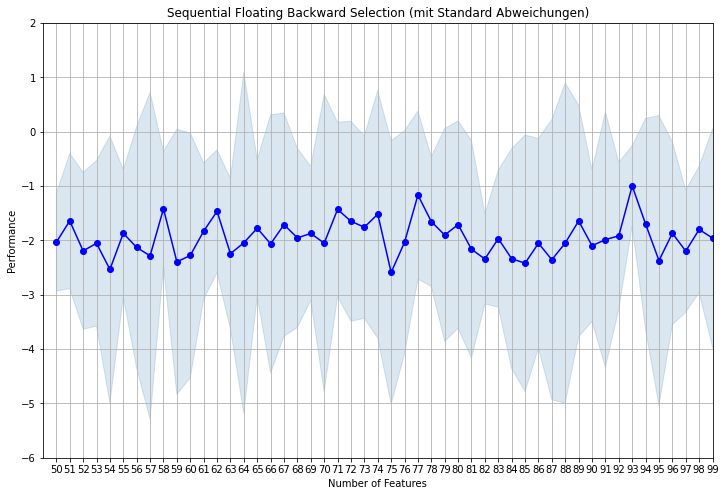

In [80]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(12, 8)
               )

plt.ylim([-6, 2])
plt.xlim([49, 99])
plt.title('Sequential Floating Backward Selection (mit Standard Abweichungen)')
plt.grid()
plt.show()

Now using the best feature subset to train the model

In [70]:
selected_features = sfs.transform(X_1)
DTR_TWO.fit(selected_features, y)

DecisionTreeRegressor(max_depth=60, max_features=6)

In [71]:
# joblib.dump(LR_ONE, data/"linear_model_10_20.joblib")
joblib.dump(sfs, data/"sbfs_dtr_2_10_20_tsfresh.joblib")

['/space/user/hdreesmann/sbfs_dtr_2_10_20_tsfresh.joblib']